In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import os
import csv
from pathlib import Path
import numpy as np

torch.manual_seed(0)
device = "cpu"


In [2]:
DATA_DIR = Path("../data")
MODEL_DIR = Path("../models")
EXP_DIR = Path("../experiments")

MODEL_DIR.mkdir(exist_ok=True)
EXP_DIR.mkdir(exist_ok=True)

RESULTS_CSV = EXP_DIR / "results.csv"
# If file doesn't exist, write header
if not RESULTS_CSV.exists():
    with open(RESULTS_CSV, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["model_name", "train_loss", "test_loss", "train_acc", "test_acc", "size_MB", "latency_sec"])


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = datasets.MNIST(
    root=DATA_DIR, train=True, download=True, transform=transform
)
test_set = datasets.MNIST(
    root=DATA_DIR, train=False, download=True, transform=transform
)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


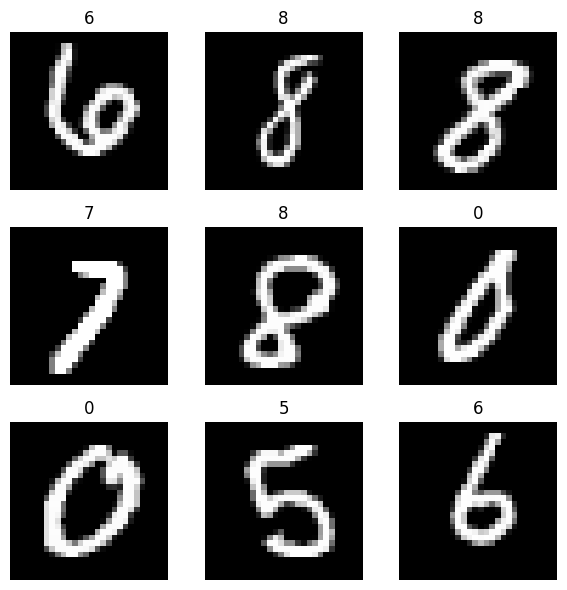

In [4]:
images, labels = next(iter(train_loader))

plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(labels[i].item())
    plt.axis("off")
plt.tight_layout()
plt.show()


In [5]:
class FFN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

model = FFN().to(device)


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5  # Adjust as needed

# Lists to store metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
latencies = []

In [7]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    start_train_time = time.time()
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_losses.append(running_loss/len(train_set))
    train_accuracies.append(100.*correct/total)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%")

/home/rebu/Desktop/Projects/Interns/Icog/training-tasks/LLM-Optimization/venv/lib/python3.12/site-packages/torch/autograd/graph.py:865: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:119.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/5], Train Loss: 0.2299, Train Acc: 93.19%
Epoch [2/5], Train Loss: 0.0945, Train Acc: 97.10%
Epoch [3/5], Train Loss: 0.0647, Train Acc: 97.88%
Epoch [4/5], Train Loss: 0.0503, Train Acc: 98.35%
Epoch [5/5], Train Loss: 0.0373, Train Acc: 98.80%


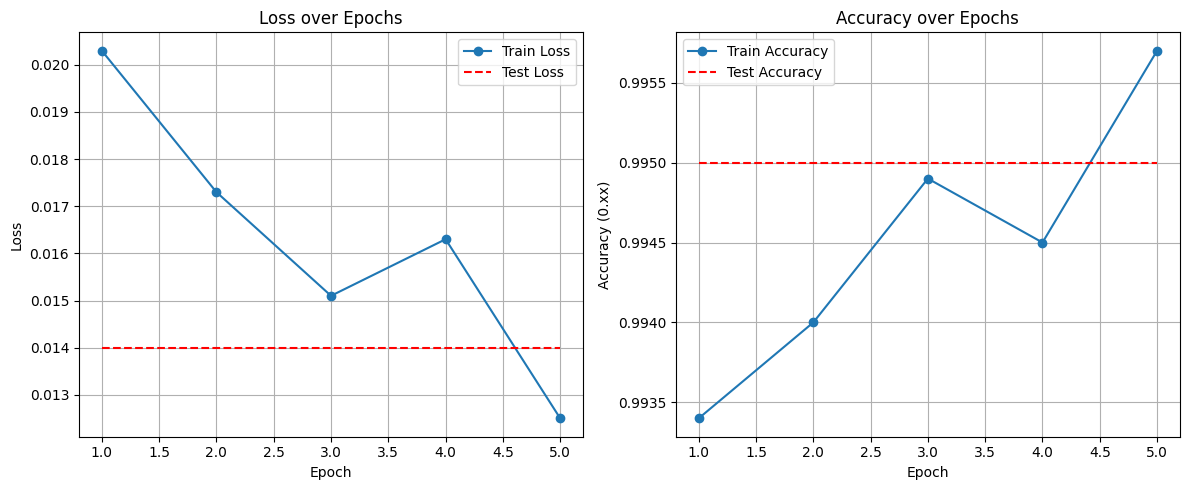

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Training data from your log
train_losses = [0.0203, 0.0173, 0.0151, 0.0163, 0.0125]
train_accuracies = [99.34, 99.40, 99.49, 99.45, 99.57]  # in %
train_accuracies = [acc/100 for acc in train_accuracies]  # convert to 0.xx format

num_epochs = len(train_losses)
epochs = np.arange(1, num_epochs + 1)

# Example: let's assume test metrics as single values (replace with real values if you have them)
test_loss = 0.0140
test_accuracy = 0.995  # 0.xx format

plt.figure(figsize=(12,5))

# --- Loss plot ---
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, marker='o', label="Train Loss")
plt.hlines(test_loss, xmin=epochs[0], xmax=epochs[-1], colors='r', linestyles='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)

# --- Accuracy plot ---
plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, marker='o', label="Train Accuracy")
plt.hlines(test_accuracy, xmin=epochs[0], xmax=epochs[-1], colors='r', linestyles='--', label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (0.xx)")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [9]:
    # Evaluate on test set
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        start_test_time = time.time()
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        end_test_time = time.time()
    
    test_losses.append(running_loss/len(test_set))
    test_accuracies.append(100.*correct/total)
    latencies.append((end_test_time - start_test_time)/len(test_loader))
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}% "
          f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}% "
          f"Latency: {latencies[-1]:.4f} sec/batch")

Epoch [5/5] Train Loss: 0.0125, Train Acc: 1.00% Test Loss: 0.0738, Test Acc: 97.84% Latency: 0.0209 sec/batch


In [10]:
model_path = MODEL_DIR / "ffn_baseline.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved at {model_path}")

# Compute model size in MB
size_MB = os.path.getsize(model_path)/1e6
print(f"Model size: {size_MB:.4f} MB")

Model saved at ../models/ffn_baseline.pth
Model size: 0.9437 MB


In [11]:
# Function to measure average inference latency per batch
def measure_latency(model, loader, n_batches=50):
    model.eval()
    timings = []
    with torch.no_grad():
        for i, (images, _) in enumerate(loader):
            if i >= n_batches:
                break
            images = images.to(device)
            start = time.time()
            _ = model(images)
            end = time.time()
            timings.append(end - start)
    avg_latency = sum(timings) / len(timings)
    return avg_latency


In [12]:
import csv

csv_path = EXP_DIR / "results.csv"

# Check if file exists to write header
file_exists = csv_path.exists()
with open(csv_path, mode="a", newline="") as f:
    writer = csv.writer(f)
    
    # Write header only if file doesn't exist
    if not file_exists:
        writer.writerow(["model", "test_accuracy", "train_accuracy", "Loss", "Size(M)", "Latency(s)"])
    
    # Compute model size in MB
    model_size_MB = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024**2)
    
    # Append metrics in 0.xx floating point format
    writer.writerow([
        "FNN_baseline",                     # model name
        float(test_accuracies[-1]),         # test_accuracy as 0.xx
        float(train_accuracies[-1]),        # train_accuracy as 0.xx
        float(test_losses[-1]),             # loss
        float(model_size_MB),               # size in MB
        float(latencies[-1])                # latency in sec
    ])

print(f"Metrics appended to {csv_path}")


Metrics appended to ../experiments/results.csv


In [ ]:
# ===============================
# FINAL: Save baseline metrics (PARAMETER-BASED SIZE)
# ===============================

import csv

# ----- Parameter-based model size (FP32) -----
num_params = sum(p.numel() for p in model.parameters())
size_MB = num_params * 4 / (1024 ** 2)

print(f"Baseline parameter count: {num_params:,}")
print(f"Baseline parameter-based size: {size_MB:.6f} MB")

csv_path = EXP_DIR / "results.csv"
file_exists = csv_path.exists()

with open(csv_path, mode="a", newline="") as f:
    writer = csv.writer(f)

    if not file_exists:
        writer.writerow([
            "model",
            "test_accuracy",
            "train_accuracy",
            "Loss",
            "Size(M)",
            "Latency(s)"
        ])

    writer.writerow([
        "FNN_baseline",
        float(test_accuracies[-1]/100),   # 0.xx
        float(train_accuracies[-1]),  # 0.xx
        float(test_losses[-1]),
        float(size_MB),               # parameter-based
        float(latencies[-1])
    ])

print(f"Baseline metrics appended to {csv_path}")


Baseline parameter count: 235,146
Baseline parameter-based size: 0.897011 MB
Baseline metrics appended to ../experiments/results.csv
